In [ ]:
# essentials
import numpy as np
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

# ml
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import joblib

In [ ]:
def print_col_type(df):
    non_num_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(exclude=['object'])
    '''separates non-numeric and numeric columns'''
    print("Object columns:")
    for col in non_num_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in num_df:
        print(f"{col}")

def missing_cols(df):
    '''prints out columns with its amount of missing values with its %'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += missing_vals
        if missing_vals != 0:
          print('{} => {} [{}%]'.format(col, df[col].isnull().sum(), round(pct, 2)))

    if total == 0:
        print("no missing values")

In [ ]:
train_a = pd.read_csv("data/comp_datasets_train/region_A_train.csv")
train_b = pd.read_csv("data/comp_datasets_train/region_B_train.csv")
train_c = pd.read_csv("data/comp_datasets_train/region_C_train.csv")
train_d = pd.read_csv("data/comp_datasets_train/region_D_train.csv")
train_e = pd.read_csv("data/comp_datasets_train/region_E_train.csv")

test_a = pd.read_csv("data/comp_datasets_test/region_A_test.csv")
test_b = pd.read_csv("data/comp_datasets_test/region_B_test.csv")
test_c = pd.read_csv("data/comp_datasets_test/region_C_test.csv")
test_d = pd.read_csv("data/comp_datasets_test/region_D_test.csv")
test_e = pd.read_csv("data/comp_datasets_test/region_E_test.csv")

labels_df = pd.read_csv("data/comp_datasets_train/solution_train.csv")

In [ ]:
train_a.head()

,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


In [ ]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     566 non-null    object 
 1   avg.temp                 566 non-null    float64
 2   max.temp                 566 non-null    float64
 3   min.temp                 566 non-null    float64
 4   precipitation            566 non-null    float64
 5   avg.wind.speed           566 non-null    float64
 6   max.wind.speed           566 non-null    float64
 7   max.wind.speed.dir       566 non-null    object 
 8   max.inst.wind.speed      566 non-null    float64
 9   max.inst.wind.speed.dir  566 non-null    object 
 10  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(3)
memory usage: 48.8+ KB


In [ ]:
print_col_type(train_a)

Object columns:
date
max.wind.speed.dir
max.inst.wind.speed.dir

Numeric columns:
avg.temp
max.temp
min.temp
precipitation
avg.wind.speed
max.wind.speed
max.inst.wind.speed
min.atmos.pressure


## EDA

In [ ]:
train_all = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
train_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    229b70a3       3.3      10.2      -2.4            0.0             2.9   
  1    3134f4ff       5.7      13.7      -2.9            0.0             3.6   
  2    dbfaf910      13.8      20.0       9.0            0.0             5.3   
  3    3aea0cf0      11.4      19.3       5.8            0.0             4.2   
  4    f0227f56       2.4       7.7       0.3           43.5             0.9   
...         ...       ...       ...       ...            ...             ...   
E 561  91b2797d       6.3      13.1       0.3            0.0             0.6   
  562  b807fd87       6.2      13.5       0.3            0.0             0.8   
  563  8e0a48e0       9.0      15.9       2.4            0.0             0.6   
  564  9df85983       5.3      13.9       0.1            0.0             1.0   
  565  c9d4fe7c       6.4      15.3      -0.2            0.0             0.7   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0               9.3                  W                 14.3   
  1              10.7                  W                 15.8   
  2               9.4                 SW                 15.2   
  3              10.1                 SW                 20.6   
  4               3.7                 SW                  5.7   
...               ...                ...                  ...   
E 561             2.2                  S                  4.3   
  562             2.3                 SW                  6.3   
  563             2.4                 NW                  5.7   
  564             3.0                  S                  6.9   
  565             2.1                 NW                  5.5   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                         W              1015.1  
  1                         W              1011.3  
  2                         W              1004.2  
  3                        SW              1001.7  
  4                        SW              1003.5  
...                       ...                 ...  
E 561                       S                 NaN  
  562                       W                 NaN  
  563                       W                 NaN  
  564                      NW                 NaN  
  565                       N                 NaN  

[2830 rows x 11 columns]

In [ ]:
train_all_lvls = train_all.reset_index()
train_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
train_all_lvls.drop(columns=['level_1'], inplace=True)
train_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


In [ ]:
train_all_lvls['region'].nunique()

5

In [ ]:
train_all_lvls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   2830 non-null   object 
 1   date                     2830 non-null   object 
 2   avg.temp                 2830 non-null   float64
 3   max.temp                 2830 non-null   float64
 4   min.temp                 2830 non-null   float64
 5   precipitation            2830 non-null   float64
 6   avg.wind.speed           2830 non-null   float64
 7   max.wind.speed           2830 non-null   float64
 8   max.wind.speed.dir       2830 non-null   object 
 9   max.inst.wind.speed      2830 non-null   float64
 10  max.inst.wind.speed.dir  2830 non-null   object 
 11  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(4)
memory usage: 265.4+ KB


In [ ]:
train_all_lvls.columns[2:]

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

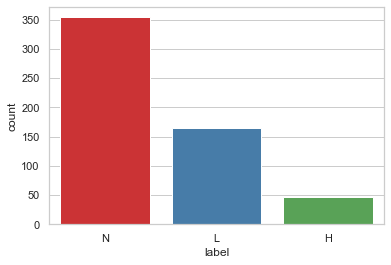

In [ ]:
sns.countplot(x = 'label', data = labels_df, palette="Set1");

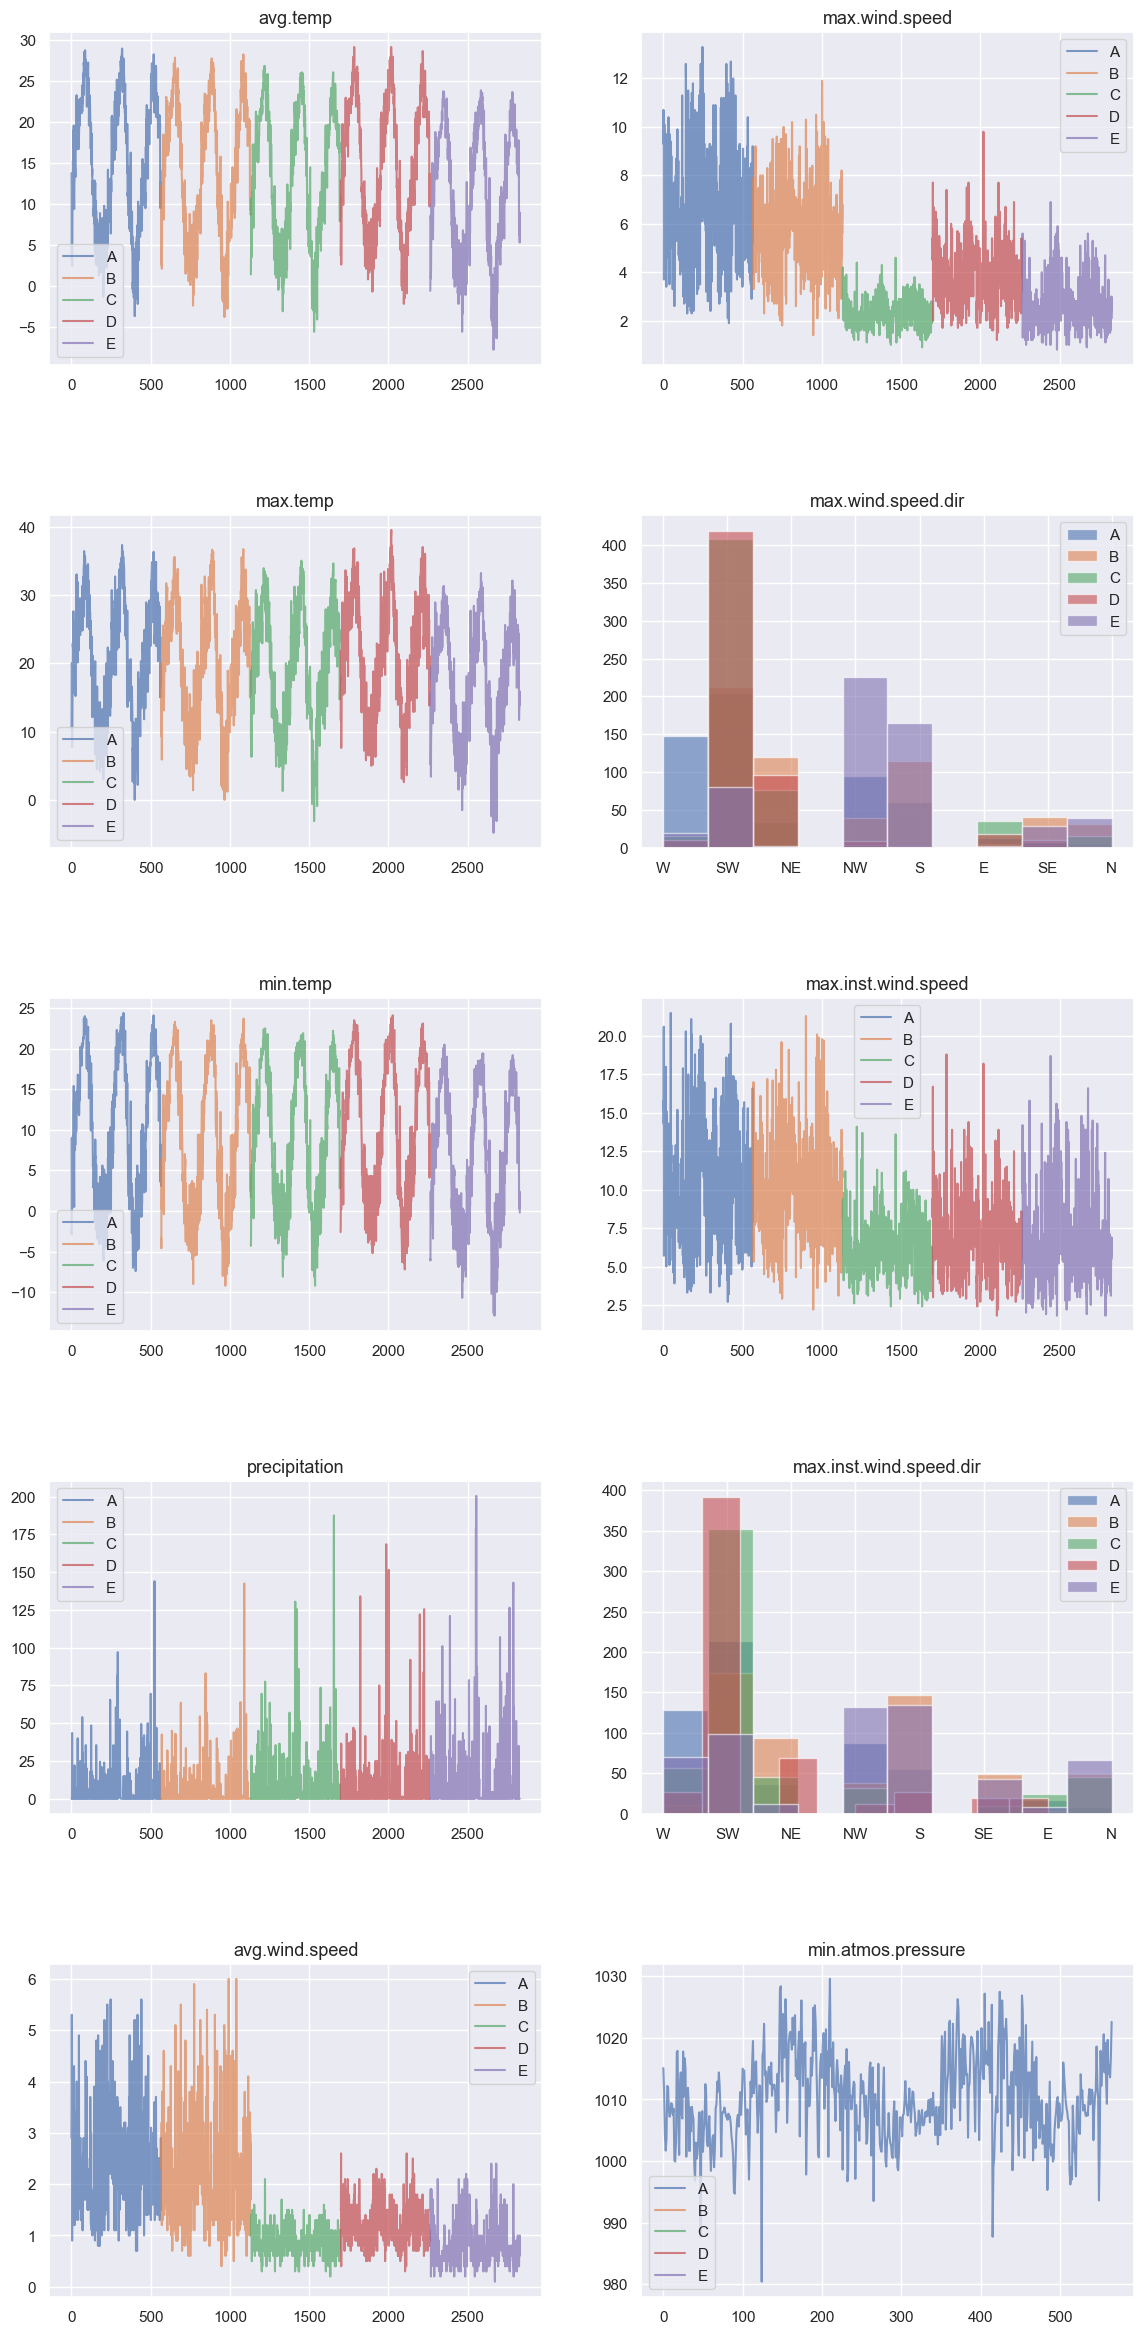

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(train_all_lvls.columns[2:]):
    if train_all_lvls[col_name].dtype == 'O':
        train_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        train_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

In [ ]:
test_all = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
test_all_lvls = test_all.reset_index()
test_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
test_all_lvls.drop(columns=['level_1'], inplace=True)
test_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


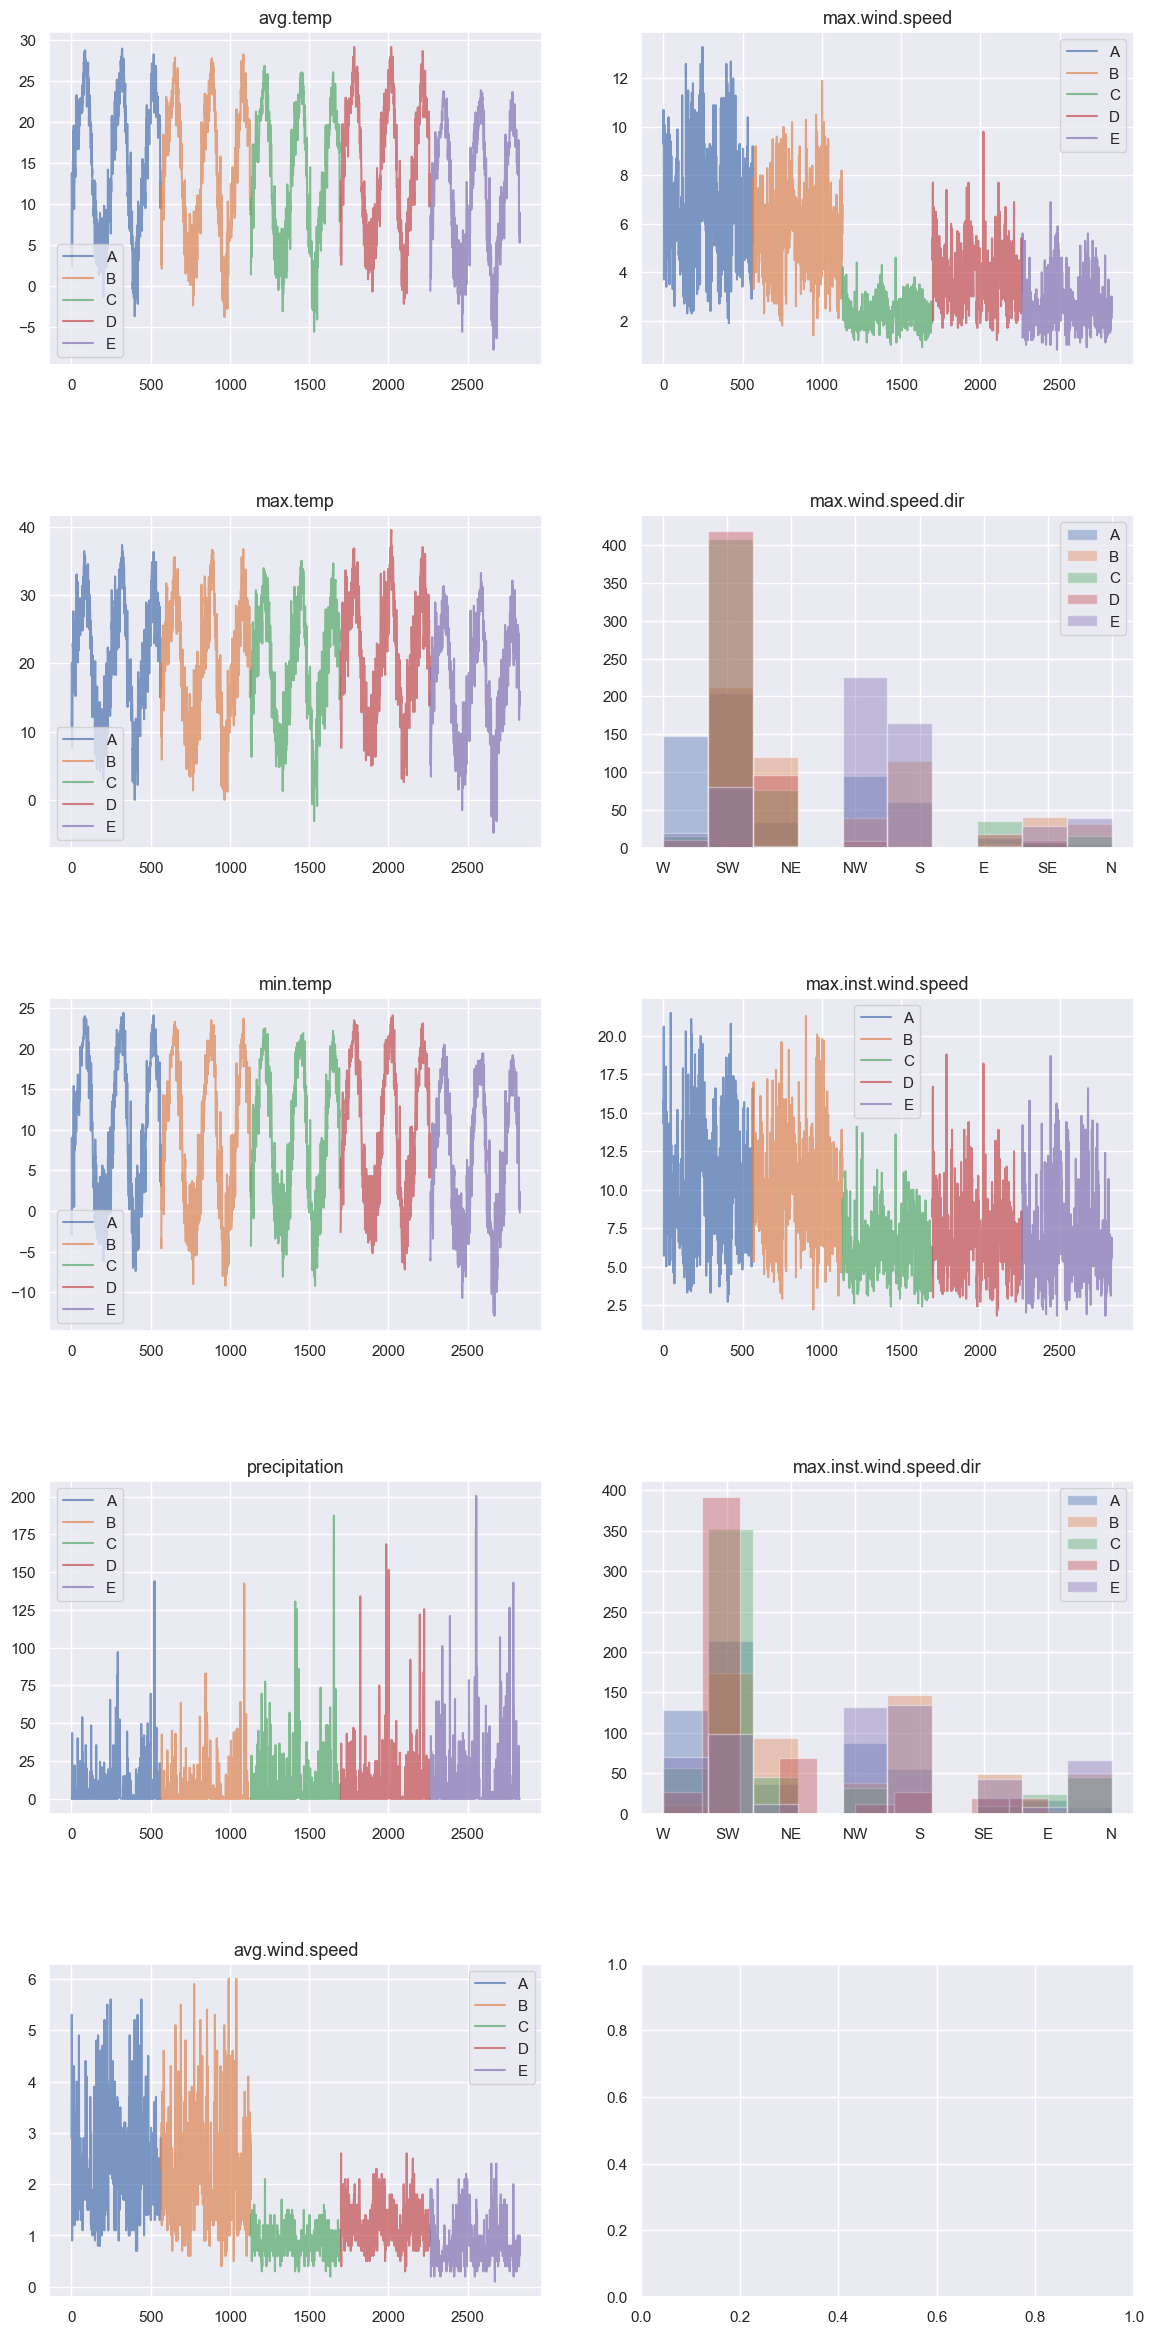

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(test_all_lvls.columns[2:-1]):
    if test_all_lvls[col_name].dtype == 'O':
        test_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.4);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        test_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

## Missing Values

In [ ]:
missing_cols(train_all_lvls)

min.atmos.pressure => 2264 [80.0%]


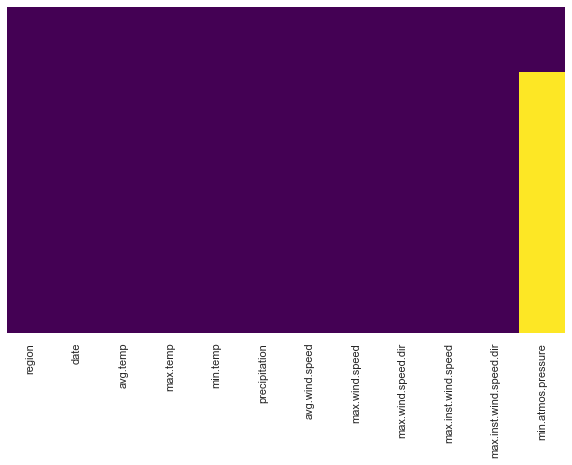

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_all_lvls.isnull(), yticklabels=False, cmap='viridis', cbar=False);

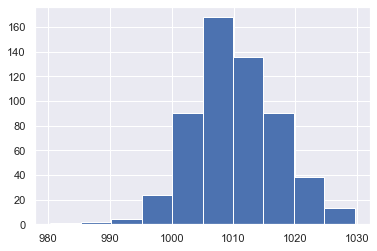

In [ ]:
train_all_lvls['min.atmos.pressure'].hist();

In [ ]:
mean_atmos = train_all_lvls['min.atmos.pressure'].mean()

In [ ]:
train_all_lvls.fillna(mean_atmos, inplace=True)

In [ ]:
missing_cols(train_all_lvls)

no missing values


In [ ]:
missing_cols(test_all_lvls)

min.atmos.pressure => 2264 [80.0%]


In [ ]:
test_all_lvls.fillna(mean_atmos, inplace=True)

In [ ]:
missing_cols(test_all_lvls)

no missing values


## Feature Engineering

In [ ]:
train_all_lvls = train_all_lvls.merge(labels_df, on="date")

In [ ]:
train_all_lvls.dtypes

region                      object
date                        object
avg.temp                   float64
max.temp                   float64
min.temp                   float64
precipitation              float64
avg.wind.speed             float64
max.wind.speed             float64
max.wind.speed.dir          object
max.inst.wind.speed        float64
max.inst.wind.speed.dir     object
min.atmos.pressure         float64
label                       object
dtype: object

In [ ]:
le = LabelEncoder()
le.fit(train_all_lvls['label'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'H': 0, 'L': 1, 'N': 2}

In [ ]:
train_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir',
       'label'],
      dtype='object')

In [ ]:
test_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir'], dtype='object')

In [ ]:
BEAUFORT = [
    (0, 0, 0.3),
    (1, 0.3, 1.6),
    (2, 1.6, 3.4),
    (3, 3.4, 5.5),
    (4, 5.5, 8),
    (5, 8, 10.8),
    (6, 10.8, 13.9),
    (7, 13.9, 17.2),
    (8, 17.2, 20.8),
    (9, 20.8, 24.5),
    (10, 24.5, 28.5),
    (11, 28.5, 33),
    (12, 33, 200),
]



def feature_eng(df):
    le = LabelEncoder()

    cat_cols = df.select_dtypes("object").columns[2:]

    for col in cat_cols:
        if df[col].dtype == "object":
            df[col] = le.fit_transform(df[col])

    for item in BEAUFORT:
        df.loc[
            (df["avg.wind.speed"] >= item[1]) & (df["avg.wind.speed"] < item[2]),
            "beaufort_scale",
        ] = item[0]

    df['beaufort_scale'] = df['beaufort_scale'].astype(int)

    return df

In [ ]:
train = feature_eng(train_all_lvls)
test = feature_eng(test_all_lvls)

## Prepare train data

In [ ]:
train.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure,label,beaufort_scale
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,7,14.3,7,1015.100000,2,2
1,B,229b70a3,2.6,9.3,-3.3,0.0,2.8,6.3,3,11.4,3,1010.216254,2,2
2,C,229b70a3,1.4,9.0,-4.3,0.0,1.0,2.9,6,8.2,1,1010.216254,2,1
3,D,229b70a3,3.7,11.7,-2.6,0.0,1.5,5.4,6,9.4,4,1010.216254,2,1
4,E,229b70a3,-0.6,5.2,-5.9,0.0,1.5,3.8,3,9.8,7,1010.216254,2,1


In [ ]:
train.dtypes

region                      object
date                        object
avg.temp                   float64
max.temp                   float64
min.temp                   float64
precipitation              float64
avg.wind.speed             float64
max.wind.speed             float64
max.wind.speed.dir           int64
max.inst.wind.speed        float64
max.inst.wind.speed.dir      int64
min.atmos.pressure         float64
label                        int64
beaufort_scale               int64
dtype: object

In [ ]:
train = train.pivot_table(index=["date", "label"], columns="region")
train = pd.DataFrame(train.to_records())
train.head()

,date,label,"('avg.temp', 'A')","('avg.temp', 'B')","('avg.temp', 'C')","('avg.temp', 'D')","('avg.temp', 'E')","('avg.wind.speed', 'A')","('avg.wind.speed', 'B')","('avg.wind.speed', 'C')",...,"('min.temp', 'A')","('min.temp', 'B')","('min.temp', 'C')","('min.temp', 'D')","('min.temp', 'E')","('precipitation', 'A')","('precipitation', 'B')","('precipitation', 'C')","('precipitation', 'D')","('precipitation', 'E')"
0,00173aec,2,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,1,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,2,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,2,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,2,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0


In [ ]:
def replace_all(text):
    d = { "('": "", "', '": "_", "')" : "",}
    for i, j in d.items():
        text = text.replace(i, j)
    return text

# ('avg.temp', 'A') -> avg.temp_A

test_str = "('avg.temp', 'A')"
replace_all(test_str)

'avg.temp_A'

In [ ]:
train.columns = list(map(replace_all, train.columns))

In [ ]:
train.columns

Index(['date', 'label', 'avg.temp_A', 'avg.temp_B', 'avg.temp_C', 'avg.temp_D',
       'avg.temp_E', 'avg.wind.speed_A', 'avg.wind.speed_B',
       'avg.wind.speed_C', 'avg.wind.speed_D', 'avg.wind.speed_E',
       'beaufort_scale_A', 'beaufort_scale_B', 'beaufort_scale_C',
       'beaufort_scale_D', 'beaufort_scale_E', 'max.inst.wind.speed_A',
       'max.inst.wind.speed_B', 'max.inst.wind.speed_C',
       'max.inst.wind.speed_D', 'max.inst.wind.speed_E',
       'max.inst.wind.speed.dir_A', 'max.inst.wind.speed.dir_B',
       'max.inst.wind.speed.dir_C', 'max.inst.wind.speed.dir_D',
       'max.inst.wind.speed.dir_E', 'max.temp_A', 'max.temp_B', 'max.temp_C',
       'max.temp_D', 'max.temp_E', 'max.wind.speed_A', 'max.wind.speed_B',
       'max.wind.speed_C', 'max.wind.speed_D', 'max.wind.speed_E',
       'max.wind.speed.dir_A', 'max.wind.speed.dir_B', 'max.wind.speed.dir_C',
       'max.wind.speed.dir_D', 'max.wind.speed.dir_E', 'min.atmos.pressure_A',
       'min.atmos.pressure_B', 

In [ ]:
test = test.pivot_table(index=["date"], columns="region")
test = pd.DataFrame(test.to_records())
test.columns = list(map(replace_all, test.columns))

In [ ]:
train

,date,label,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,00173aec,2,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,1,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,2,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,2,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,2,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,fe2a1385,1,2.9,1.6,1.4,3.4,0.4,1.2,0.9,0.7,...,-4.0,-5.9,-2.8,-3.4,-5.9,0.0,0.0,0.0,0.0,0.0
562,fe6dd99c,1,2.9,2.9,3.9,2.9,0.2,1.6,3.9,1.0,...,1.7,1.4,1.9,1.0,-1.2,2.0,1.0,2.0,4.0,8.0
563,ff88c3dd,1,9.8,8.9,9.0,10.2,6.3,1.9,1.5,1.4,...,1.5,-0.1,2.0,2.5,-1.9,0.0,0.0,0.0,0.0,0.0
564,ff929090,2,10.4,8.1,7.1,11.0,5.7,4.3,4.6,0.9,...,3.4,1.5,-0.6,3.2,-1.6,0.0,3.5,5.5,0.0,1.5


In [ ]:
test

,date,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,avg.wind.speed_D,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,00173aec,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,1.2,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,1.3,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,1.0,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,1.8,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,fe2a1385,2.9,1.6,1.4,3.4,0.4,1.2,0.9,0.7,0.9,...,-4.0,-5.9,-2.8,-3.4,-5.9,0.0,0.0,0.0,0.0,0.0
562,fe6dd99c,2.9,2.9,3.9,2.9,0.2,1.6,3.9,1.0,0.7,...,1.7,1.4,1.9,1.0,-1.2,2.0,1.0,2.0,4.0,8.0
563,ff88c3dd,9.8,8.9,9.0,10.2,6.3,1.9,1.5,1.4,1.5,...,1.5,-0.1,2.0,2.5,-1.9,0.0,0.0,0.0,0.0,0.0
564,ff929090,10.4,8.1,7.1,11.0,5.7,4.3,4.6,0.9,2.0,...,3.4,1.5,-0.6,3.2,-1.6,0.0,3.5,5.5,0.0,1.5


## Build the LightGBM model

Following set of practices can be used to improve your model efficiency.

1. num_leaves : This is the main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.
2. min_data_in_leaf : Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
3. max_depth : We also can use max_depth to limit the tree depth explicitly.

For Faster Speed
- Use bagging by setting bagging_fraction and bagging_freq.
- Use feature sub-sampling by setting feature_fraction.
- Use small max_bin.
- Use save_binary to speed up data loading in future learning.

For better accuracy
- Use large max_bin (may be slower).
- Use small learning_rate with large num_iterations
- Use large num_leaves(may cause over-fitting)
- Use bigger training data
- Try dart
- Try to use categorical feature directly.

To deal with over-fitting
- Use small max_bin
- Use small num_leaves
- Use min_data_in_leaf and min_sum_hessian_in_leaf
- Use bagging by set bagging_fraction and bagging_freq
- Use feature sub-sampling by set feature_fraction
- Use bigger training data
- Try lambda_l1, lambda_l2 and min_gain_to_split to regularization
- Try max_depth to avoid growing deep tree

In [ ]:
train.dtypes

date                          object
label                          int64
avg.temp_A                   float64
avg.temp_B                   float64
avg.temp_C                   float64
avg.temp_D                   float64
avg.temp_E                   float64
avg.wind.speed_A             float64
avg.wind.speed_B             float64
avg.wind.speed_C             float64
avg.wind.speed_D             float64
avg.wind.speed_E             float64
beaufort_scale_A               int64
beaufort_scale_B               int64
beaufort_scale_C               int64
beaufort_scale_D               int64
beaufort_scale_E               int64
max.inst.wind.speed_A        float64
max.inst.wind.speed_B        float64
max.inst.wind.speed_C        float64
max.inst.wind.speed_D        float64
max.inst.wind.speed_E        float64
max.inst.wind.speed.dir_A      int64
max.inst.wind.speed.dir_B      int64
max.inst.wind.speed.dir_C      int64
max.inst.wind.speed.dir_D      int64
max.inst.wind.speed.dir_E      int64
m

In [ ]:
categoricals = list(train.select_dtypes(include=['int64']).columns)
categoricals.remove("label")
numericals = list(train.select_dtypes(include=['float64']).columns)

feat_cols = categoricals + numericals

In [ ]:
X = train[feat_cols]
y = train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
clf = lgb.LGBMClassifier()

clf.fit(X_train, y_train)

LGBMClassifier()

## Model Prediction

In [ ]:
y_pred=clf.predict(X_test)

## Model performance

In [ ]:
acc_score = accuracy_score(y_pred, y_test)
recall_score = recall_score(y_pred, y_test, average='macro')
print(f"Accuracy: {acc_score}, recall: {recall_score}")

Accuracy: 0.5941176470588235, recall: 0.4701662292213474


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.44      0.42         9
           1       0.33      0.21      0.26        52
           2       0.68      0.79      0.73       109

    accuracy                           0.59       170
   macro avg       0.47      0.48      0.47       170
weighted avg       0.56      0.59      0.57       170



## Confusion matrix

In [ ]:
class_names = le_name_map.keys()

Confusion matrix, without normalization
[[ 4  3  2]
 [ 2 11 39]
 [ 4 19 86]]
Normalized confusion matrix
[[0.44444444 0.33333333 0.22222222]
 [0.03846154 0.21153846 0.75      ]
 [0.03669725 0.17431193 0.78899083]]


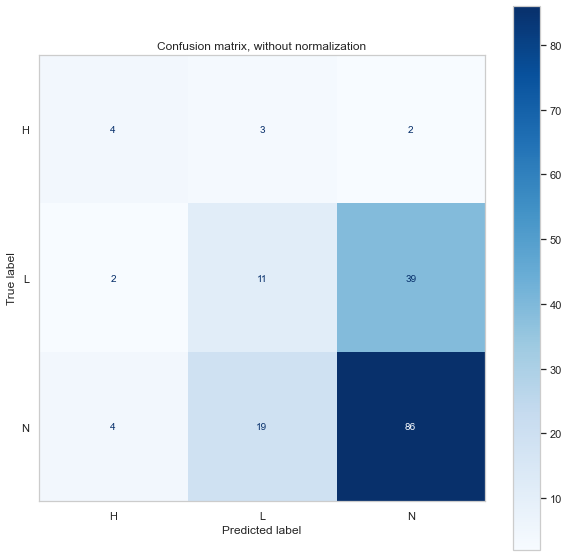

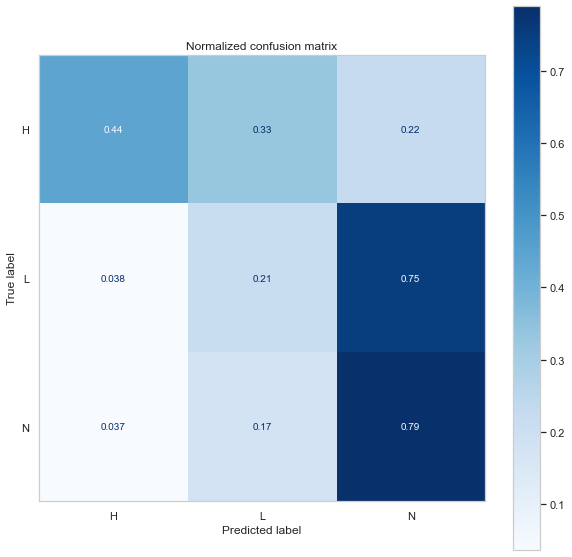

In [ ]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))

    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

## Check for overfitting

In [ ]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.5941


## Feature importance

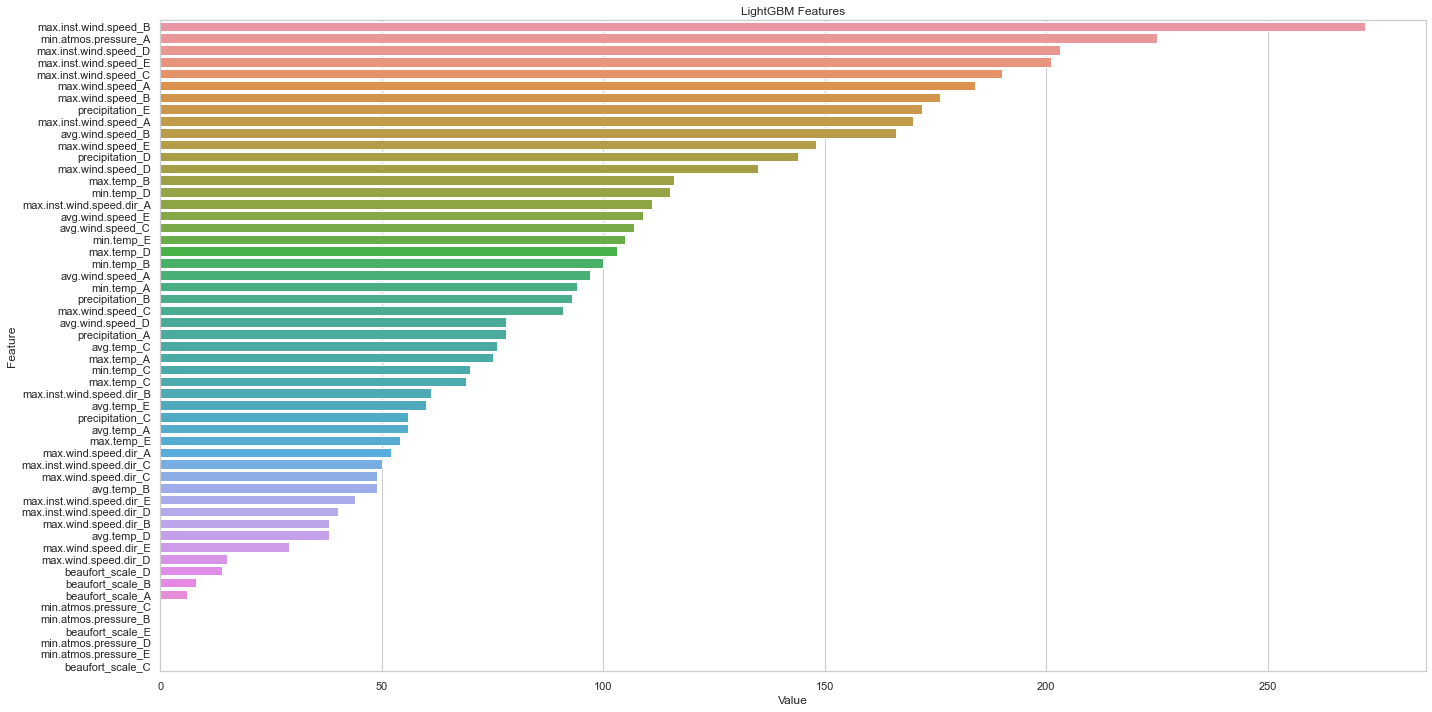

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
# plt.savefig('lightgbm_fimp.png')

## Save the model

In [ ]:
joblib.dump(clf, 'lgb1.pkl')

['lgb1.pkl']

## Predict on test data

In [ ]:
X = test[feat_cols]

In [ ]:
test_preds = clf.predict(X)
submission_df = pd.concat([test['date'], pd.DataFrame(test_preds, columns=['label'])], axis=1)
submission_df.head()

,date,label
0,00173aec,2
1,0083f291,1
2,014cfe7b,2
3,01947c8e,2
4,0258884d,2


In [ ]:
le_name_map

{'H': 0, 'L': 1, 'N': 2}

In [ ]:
inv_map = {v: k for k, v in le_name_map.items()}
inv_map

{0: 'H', 1: 'L', 2: 'N'}

In [ ]:
submission_df['label'] = submission_df['label'].map(inv_map)
submission_df.head()

,date,label
0,00173aec,N
1,0083f291,L
2,014cfe7b,N
3,01947c8e,N
4,0258884d,N


## Solution file

In [ ]:
submission_df.to_csv('solution.csv', index=False)